**This article is now interactive! Check out a live Binder instance [here](http://mybinder.org/repo/choldgraf/choldgraf.github.io/notebooks/notebooks/2016_11_30-funnel_plots.ipynb)**

In the next few months, I'll try to take some time to talk about the things I learn as I make my way through this literature. While it's easy to make one-off complaints to one another about how "science is broken" without really diving into the details, it's important learn about *how* it's broken, or at least how we could assess something like this.

Fortunately, there are a lot of great researchers out there who are studying these very issues. Whether they dedicate all of their research to these "meta science" topics, or simply treat this as a part of their scientific duty on top of their domain-specific work, their work represents a crucial step in reforming our scientific culture.

I'm not really dredging up anything new here. People have spoken at length about scientific principles and how to improve them for quite a long time. However, I've found that these insights often come buried within relatively dense papers that are themselves hidden behind subscription journal paywalls. This is an attempt to make these thoughts a little more digestible, discoverable, and useful.

Read on below to learn about why funnel plots are a great way to visualize the problems our publishing system faces...

In [ ]:
# Some quick imports we'll use later
import numpy as np
from scipy.stats import distributions
from matplotlib import pyplot as plt
from IPython.html.widgets import interact
from IPython.display import Image
%matplotlib inline

# On to Funnel Plots
> (note, all of the plots are taken from the excellent paper *[The Rules of the Game of Psychological Science](http://pps.sagepub.com/content/7/6/543.full)*, though funnel plots date back at least to the book *[Summing Up](http://www.hup.harvard.edu/catalog.php?isbn=9780674854314)* by Light and Lillemer)

Before diving into the guts of funnel plots, we first need to talk about experiments and effect sizes.

The (theoretical) goal of science is to observe and accurately describe various phenomena in nature. One way to do this is to conduct some experimental manipulation (e.g., drinking variable amounts of coffee), and measuring its effect on a dependent variable (e.g., how many minutes I spend cleaning my kitchen). Many scientists conduct similar experiments, and report the effect size they found in their papers (e.g., when Chris drinks 2 cups of coffee, he cleans his kitchen an average of 1 hour longer).

We can aggregate the reported effect size across many papers in order to determine an even "truer" effect, one that removes experimenter bias and noise. This is similar to how poll aggregators theoretically remove noise by combining the results of many different polls (unless of course [pollsters are systematically biased](http://fivethirtyeight.com/features/the-polls-missed-trump-we-asked-pollsters-why/)). The result is a number that is closer to reality.

Or is it?

One big problem with this is that scientists don't report all of their findings. They only report the ones they (or the journal publishers) deem "significant". In practice, this means that the effect has to be non-zero, because nobody wants to hear about null results (even though, you know, that's the vast majority of science). As a result, publishing is skewed in the direction of positive findings, and those that argue for more skepticism about whether an effect actually exists are often asked to please go back to the bench until they can come back with some sexier results.

Now, on to funnel plots.

The result of this whole situation is that the scientific literature probably overestimates effect sizes and their "significance". How much so? Well, with the advent of digital technologies it has become much easier to aggregate information across scientific studies. This means that we can look for patterns in the reported effect sizes, and determine whether there's something fishy going on (spoiler alert: there usually is.)

The funnel plot is one tool for visualizing and determining whether there is a positive skew in the literature for a given scientific finding (e.g., the relationship between coffee and my cleaning habits). Here's what it looks like:

<img src='../../images/2016/funnel_plots/funnel_plot_no_dists.png' style="width:70%" />

It's a bit busy, but the underlying ideas here are pretty simple.

* The x-axis is the size of an effect (here it's correlation but it could be any other statistic). 0 in the middle representing "no effect" and the extremes on either end representing the maximum possible effect for correlation values (in this case). 
* The right y-axis is the statistical power of the study. That is, the likelihood of concluding that an effect is "significantly" different from 0. As power increases and for a fixed effect size, it becomes more likely that we conclude significance.
* This is related to the left y-axis, which is the inverse of the sample size. AKA, smaller samples -> higher standard error -> less power -> smaller y-values. Larger samples -> lower standard error -> more power -> higher y-values.
* Finally, the shaded region tells us combinations of effect sizes / sample sizes that would be deemed "significant" (and publishable). If we assume a (two-sided) p-value threshold of .05, the area in white wouldn't make it into literature, while the area in grey would.

A funnel plot visually shows that as our sample size goes down, our statistical power also goes down. This means that with smaller sample sizes, we need a larger effect in order to conclude that our results are significant (and get them into *Nature*). Seems reasonable, so where's the problem?

The issue lies in the aforementioned positive effect bias in scientific publishing. Because null effects won't ever make it into the literature, the effect size we aggregate across papers will only draw from those that fall outside of the white inner region.

<img src='../../images/2016/funnel_plots/funnel_plot_pub_no_pub.png' style="width:70%" />

This is a problem because the whole point of science is to estimate the "true" underlying distribution of an effect, as opposed to merely determining whether it is "different from zero". So, let's show the "true" and "reported" distributions at the top and see what happens.

<img src='../../images/2016/funnel_plots/funnel_plot.png' style="width:70%" />

On the top of the funnel plot we can see the two distributions at play. In green is the "null" distribution, meaning the set of results we'd expect to see if there was really no statistical effect. Now we have more explanation for the white region of non-significance in the middle. As we have smaller sample sizes (lower y-values), the noise increases, and we'd expect more variability under the null distribution. This is why we need a really large effect size to conclude that there's really something going on.

Now look at the "alternative" hypothesis in red. This is the "experimental" distribution of this statistic, as determined from the results combined across many studies that estimate this effect. From these results, it looks like it is quite different from the "null" distribution. Hooray, science has found an effect!

But wait a second, there's something funny about these results. Notice how the datapoints (the effect sizes in reported studies) seem to follow the boundary between the white and the grey regions? Also note that they don't look symmetric around the mean of the "experimental" distribution. That's positive publication bias in action.

The reason that data points follow the boundary between white / grey isn't because that's the "truth", but because our publishing system and scientific incentives suppress findings that lie in the white region. It doesn't mean these data points don't exist, they just lie in the filing cabinets of labs all of the world who aren't able to publish results that aren't significant. As a result, we get a skewed idea of what the true effect size is.

There's another problem with this plot. As we've noted, small sample sizes means that you can only write papers with really large effect sizes. Seems reasonable, but if you can't report non-significant results, it means that studies with a smaller N are the most likely to throw off our belief about the true effect size.

## Getting our hands dirty with some code
But this is all very theoretical...to show how this works, we'll investigate funnel plots with a quick simulation to drive the point home. 

We'll simulate 10,000 studies, each with an N ranging from 2 to 50. We'll ignore all of the "questionable scientific practices" that the article mentions, and only focus on the problem of not reporting scientific results. Let's see what happens:

**Note: you can skip reading the code below if you like, as it just defines some functions that will be useful, but feel free to dig into the code if you like**

In [ ]:
# Helper functions to simulate experiments.
def simulate_data(effect, variance, n):
    """Simulate a population of data. We'll sample from this in each study.
    Note that we're drawing from a normal distribution."""
    data = np.sqrt(true_variance) * np.random.randn(int(n))
    data += effect
    return data

def simulate_experiments(data, n_min=10, n_max=50, prefer_low_n=False,
                         n_simulations=100):
    """Randomly simulates data collection and analyses of many experiments.
    
    On each iteration, it chooses a random sample from data, calculates the
    mean of that sample, as well as a p-value associated with that mean's
    difference from 0.
    
    data : the full population dataset
    n_min : the minimum sample size for each study.
    n_max : the maximum sample size for each study.
    prefer_low_n : whether lower sample sizes are preferred.
    """
    effects = np.zeros(n_simulations)
    n = np.zeros(n_simulations)
    p = np.zeros(n_simulations)
    for ii in range(n_simulations):
        # Take a random sample from the population
        if prefer_low_n is False:
            n_sample = np.random.randint(n_min, n_max, 1)[0]
        else:
            probabilities = np.logspace(5, 1, n_max - n_min)
            probabilities /= np.sum(probabilities)
            n_sample = np.random.choice(range(n_min, n_max),
                                        p=probabilities)
        ixs_sample = random_indices[ii][:n_sample]
        i_data = data[ixs_sample]
        effects[ii] = np.mean(i_data)
        n[ii] = n_sample
        p[ii] = calculate_stat(np.mean(i_data), np.std(i_data), n_sample)
    return effects, n, p

def calculate_stat(mean, std, n, h0=0):
    """Calculate a p-value using a t-test.
    
    Note that this probably *isn't* the right test to run with data that
    is bounded on either side (in this case, -1 and 1). However, luckily
    this is not a statistics tutorial so I'm just going to be blissfully
    ignorant of this.
    """
    t = (mean - h0) / (std / np.sqrt(n))
    p = distributions.t.pdf(t, n-1)
    return p


def plot_funnel_plot(effects, sample_sizes,
                     effects_reported, sample_sizes_reported,
                     p_effects_reported):
    """Creates a funnel plot using a 'full' set of effects, corresponding
    to the effects we'd report if all results were published, regardless of
    their 'significance', as well as a 'reported' set of effects which made
    it through peer review"""
    # Create a figure w/ 2 axes
    fig = plt.figure(figsize=(5, 5))
    axdist = plt.subplot2grid((4, 4), (0, 0), 1, 4)
    axmesh = plt.subplot2grid((4, 4), (1, 0), 3, 4)

    # Calculate relevant stats
    mn_full = effects.mean()
    std_full = effects.std()
    mn_pub = effects_reported.mean()
    std_pub = effects_reported.std()
    
    mn_diff = np.abs(mn_full - mn_pub)
    std_diff = np.abs(std_full - std_pub)
    
    # First axis is a histogram of the distribution for true/experimental effects
    bins = np.arange(-2, 2, .1)
    _ = axdist.hist(effects, color='k', histtype='stepfilled',
                    normed=True, bins=bins)
    _ = axdist.hlines(4.5, mn_full - std_full, mn_full + std_full,
                      color='.3', lw=2)
    _ = axdist.hist(effects_reported, color='r', histtype='step', lw=2,
                    normed=True, bins=bins)
    _ = axdist.hlines(4.0, mn_pub - std_pub, mn_pub + std_pub,
                      color='r', lw=2)
    axdist.set_ylim([0, 5])
    axdist.set_title('Distribution of effects\nError in mean: {:.3f}'
                     '\nError in std: {:.3f}'.format(mn_diff, std_diff))
    axdist.set_axis_off()

    # Now make the funnel plot
    sig = pvals < .05
    mesh = axmesh.contour(combinations[0], combinations[1], sig, cmap=plt.cm.Greys,
                          vmin=0, vmax=3, rasterized=True)
    
    inv_p_effects = 1 - p_effects_reported
    axmesh.scatter(effects, sample_sizes,
                   s=100, c='k', alpha=.1)
    axmesh.scatter(effects_reported, sample_sizes_reported,
                   s=100, c=inv_p_effects,
                   vmin=.95, vmax=1., cmap=plt.cm.viridis)
    axmesh.axis('tight')
    axmesh.set_xlabel('Effect Size')
    axmesh.set_ylabel('Sample Size (or statisical power)')

    _ = plt.setp(axdist, xlim=axmesh.get_xlim())
    return fig

# Simulating the population
Here we'll create a population of datapoints corresponding to the effect of each person. Experiments are performed by taking a random sample from that population, and calculating the average effect of the sample. For each experiment we'll choose a random number for the sample size as well. That means that we'll get a collection of sample sizes, effect sizes, and p-values. One set for each simulated experiment.

In [ ]:
# This is the true value and variance of our variable of interest.
# Remember, it's bounded between -2 and 2
true_value = .5
true_variance = 2

# This creates the contour to show the "significance edge" of the plot
n_simulations = 200
effect_sizes = np.linspace(-2, 2, 1000)
ns = np.arange(2, 100, .1)
combinations = np.meshgrid(effect_sizes, ns)
pvals = calculate_stat(combinations[0], np.sqrt(true_variance),
                       combinations[1])

# How many simulations will we run, and how large is the full population
total_population = 1e5
n_min, n_max = 5, 100

# We'll pre-define these because they take a while
population_indices = np.arange(total_population).astype(int)
random_indices = [np.random.permutation(population_indices)
                  for _ in range(n_simulations)]

# First create our population data
data = simulate_data(true_value, true_variance, total_population)

# Simulate a bunch of random effects, along w/ sample size and p-value for each
effects, n, p = simulate_experiments(data, n_min=n_min, n_max=n_max,
                                     n_simulations=n_simulations)

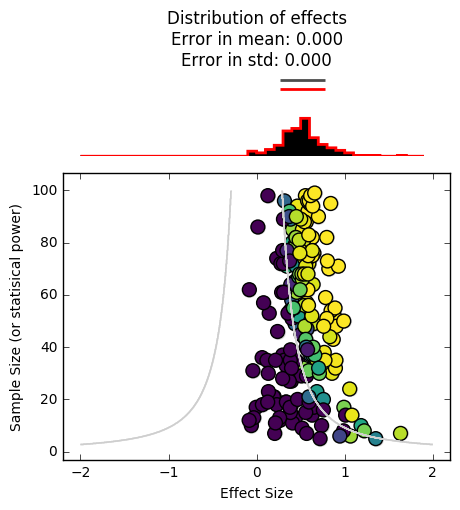

In [ ]:
# In this case, the reported and actual effects are the same
_ = plot_funnel_plot(effects, n, effects, n, p)

In the funnel plot above, each datapoint corresponds to the effect size found in a single study (x-axis), along with its sample size (y-axis).

The contour lines show us the "significance cutoffs".

The distributions at the top show us the effect size distribution for *all* experiments, as well as the distribution for only the *reported* experiments. In this case, those distributions are the same because all of our scientific experiments reported their results. We have an accurate idea of the effect size.

# Simulate the scientific publishing world
Now, let's simulate the scientific publishing process and see what happens. We'll take a relatively generous take on things, and say that studies with a p-value > .05 still have a small chance of being accepted.

In [ ]:
# This simulates which datapoints we keep and which we throw out
def simulate_publishing(pvals, null_perc=.01, pos_p_perc=.5, super_p_perc=.9):
    """Given a collection of p-vals, randomly choose ones to accept for
    publication, with the likelihood of acceptance varying with the size
    of the p-value."""
    keep = np.zeros_like(pvals).astype(bool)
    for i, ip in enumerate(pvals):
        flip = np.random.rand()
        if ip > .05:
            this_perc = null_perc
        elif ip > .005 and ip < .05:
            this_perc = pos_p_perc
        else:
            this_perc = super_p_perc
        keep[i] = True if flip < this_perc else False
    return keep

def plot_simulation_results(p_values, mask_reported):
    """A quick way to viz which papers get accepted and which don't"""
    fig, ax = plt.subplots()
    sc = ax.scatter(range(len(p_values)), p_values,
                      c=mask_reported, s=50, cmap=plt.cm.viridis,
                      vmin=0, vmax=1)
    ax.axhline(.05, ls='--')
    _ = plt.setp(ax, ylabel="p-value", xlabel="study number",
                 title='Accepted and rejected studies')
    return ax

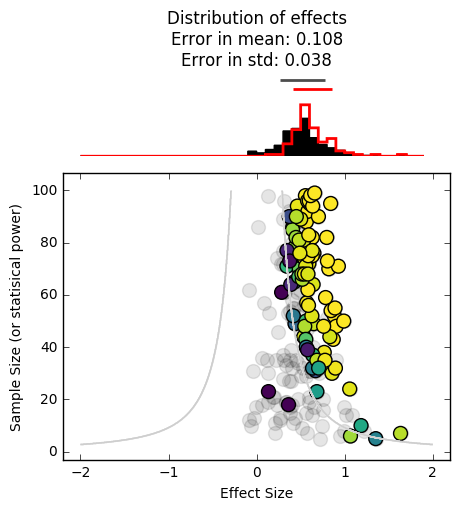

In [ ]:
mask_reported = simulate_publishing(p, null_perc=.1, pos_p_perc=.5,
                                    super_p_perc=.9)
effects_reported = effects[mask_reported]
n_reported = n[mask_reported]
p_reported = p[mask_reported]
_ = plot_funnel_plot(effects, n, effects_reported, n_reported, p_reported)

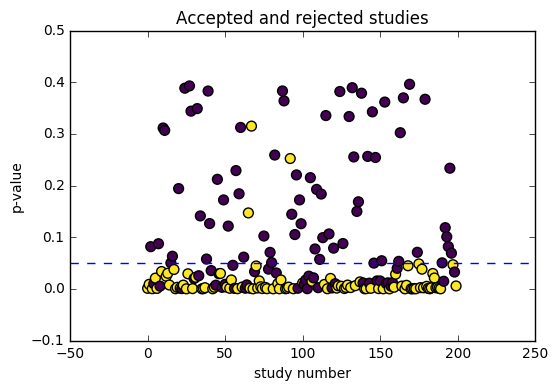

In [ ]:
plot_simulation_results(p, mask_reported)

We can already see that we've skewed the distribution of *reported* findings (in red) further to the right. This is because it is less likely for experiments inside the contour lines to be reported in the literature, making us think that the effect size is larger than it really is.

Now, let's take a more cynical look at scientific publishing by reducing the likelihood that studies are published w/o a "significant" result:

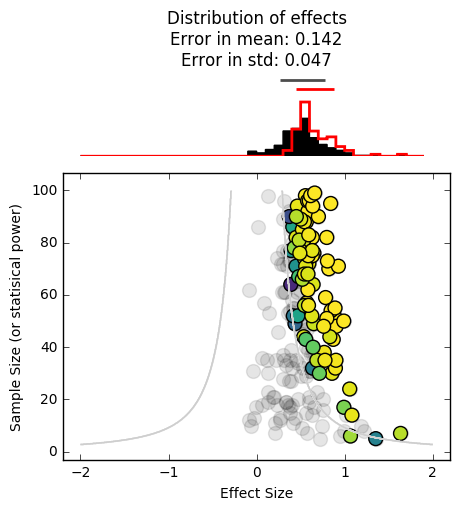

In [ ]:
mask_reported = simulate_publishing(p, null_perc=0, pos_p_perc=.3,
                                    super_p_perc=.99)
effects_reported = effects[mask_reported]
n_reported = n[mask_reported]
p_reported = p[mask_reported]
_ = plot_funnel_plot(effects, n, effects_reported, n_reported, p_reported)

It's skewed even further to the right. As you can see, the harder it is to publish null results, the more overconfident we will be in the significance of what's in the literature. As you can probably tell, this is especially problematic for effect sizes lie near the boundary between publishable / non-publishable.

# Adding a low-N bias
As we mentioned above, there's one more factor at play that makes things even worse. Smaller studies take less time and less resources to conduct, and in practice there are *far* more tiny studies than large, highly-powered ones. Let's incorporate that into our data simulation and see how that affects things.

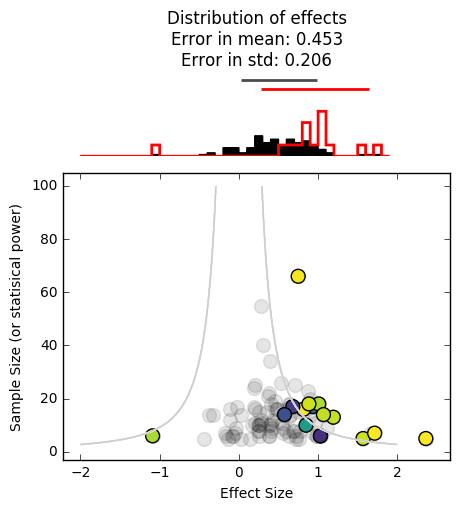

In [ ]:
# This simulates data where there is about a 10 times higher chance for a low-n study
effects, n, p = simulate_experiments(data, n_min=n_min, n_max=n_max,
                              prefer_low_n=True)  

mask_reported = simulate_publishing(p, null_perc=0., pos_p_perc=.3,
                                    super_p_perc=.99)
effects_reported = effects[mask_reported]
n_reported = n[mask_reported]
p_reported = p[mask_reported]

_ = plot_funnel_plot(effects, n, effects_reported, n_reported, p_reported)

It's even worse. As you can see, both of these factors (studies with a low N, not being able to publish null results) give the scientific community an unrealistic idea of the true effect size. Moreover, we haven't even incorporated any experimenter-specific biases, such as defining datapoints that nullify an effect as "outliers", not reporting studies that are significant but in the *opposite* direction of what we'd expect, and collecting more data until they achieve a significant p-value. All of these practices would serve to enhance the positive bias seen above.

In many cases, this might cause us to conclude that there *is* an effect, when in reality there is not. Unfortunately, this often has wide-ranging implications for things like policy decisions, and at the least causes scientists to be ineffective and inefficient at asking questions about the world.

All of this is not to say that science "doesn't work", but it's important to remember that science is about methodology before anything else, and the tools of empiricism and peer review are in constant evolution as we learn more about the pitfalls of our current approach. This is one way to identify these pitfalls, and hopefully in future years the community will adapt in order to avoid them.

# Try it yourself!
If you're curious about how all of these factors (effect size, effect variability, sample size, and publishing practices) interact, here's a quick function to let you play around with each one and determine what the effect would look like in the literature. There are particular circumstances in which these issues are most apparent, and most problematic. See if you can figure out what those circumstances are.

In [ ]:
# Create datasets with new effects / variances here
effect = .5
variance = 3
n_population = 1e6
n_simulations = 100
data = simulate_data(effect, variance, n_population)

# We'll pre-define these because they take a while
population_indices = np.arange(len(data)).astype(int)
random_indices = [np.random.permutation(population_indices)
                  for _ in range(n_simulations)]

sample_min = 4
sample_max = 100
prefer_low_n = True
effects, n, p = simulate_experiments(data, n_min=sample_min, n_max=sample_max,
                     prefer_low_n=prefer_low_n, n_simulations=n_simulations)

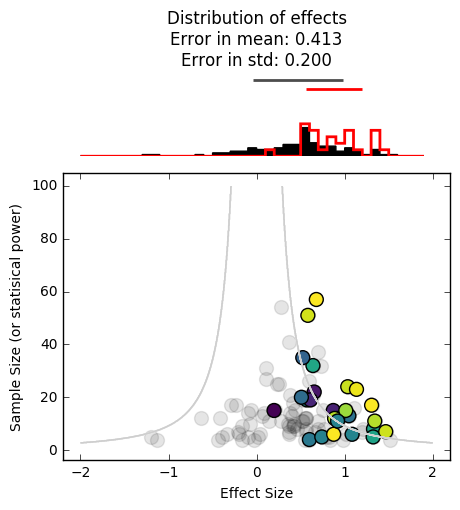

In [ ]:
def plot_simulated_data(null_perc=.05, pos_perc=.5, super_p_perc=1.):
    """
    null_perc = Chance of accepting paper w/ a null result (p<.05)
    pos_perc = Chance of accepting a paper w/ a moderate effect size
    super_p_perc = Chance of accepting a paper w/ a big effect size
    """
    mask_reported = simulate_publishing(
        p, null_perc=null_perc, pos_p_perc=pos_perc, super_p_perc=super_p_perc)
    effects_reported = effects[mask_reported]
    n_reported = n[mask_reported]
    p_reported = p[mask_reported]
    plot_funnel_plot(effects, n, effects_reported, n_reported, p_reported)
    
interact(plot_simulated_data,
         null_perc=[0., 1., .01],
         pos_perc=[0., 1., .01],
         super_p_perc=[0., 1., .01])